Set blur kernel and some util

In [ ]:
#util: https://github.com/GaryMataev/DeepRED
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def get_fft_h(im, blur_type):
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    ch, h, w = im.shape
    fft_h    =  np.zeros((h,w),)
    if blur_type=='uniform_blur':
        t        =  4 # 9//2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = 1/81
        fft_h    = np.fft.fft2(np.fft.fftshift(fft_h))
    else: # gauss_blur
        psf = fspecial_gauss(25, 1.6)
        t = 12 # 25 // 2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = psf
        fft_h    =  np.fft.fft2(np.fft.fftshift(fft_h))
    return fft_h


def blur(im, blur_type):
    fft_h = get_fft_h(im, blur_type)
    imout = np.zeros_like(im)
    for i in range(im.shape[0]):
        im_f    =  np.fft.fft2(im[i, :, :])
        z_f     =  fft_h*im_f # .* of matlab
        z       =  np.real(np.fft.ifft2(z_f))
        imout[i, :, :] = z
    return imout


# - the inverse function H - 
def get_h(n_ch, blur_type, use_fourier, dtype):
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    if not use_fourier:
        return Downsampler(n_ch, 1, blur_type, preserve_size=True).type(dtype)
    return lambda im: torch_blur(im, blur_type, dtype)


def torch_blur(im, blur_type, dtype):
    fft_h = get_fft_h(torch_to_np(im), blur_type)
    fft_h_torch = torch.unsqueeze(torch.from_numpy(np.real(fft_h)).type(dtype), 2)
    fft_h_torch = torch.cat([fft_h_torch, fft_h_torch], 2)
    z = []
    for i in range(im.shape[1]):
        im_torch = torch.unsqueeze(im[0, i, :, :], 2)
        im_torch = torch.cat([im_torch, im_torch], 2)
        im_f    =  torch.fft(im_torch, 2)
        z_f     =  torch.mul(torch.unsqueeze(fft_h_torch, 0), torch.unsqueeze(im_f, 0)) # .* of matlab
        z.append(torch.ifft(z_f, 2))
    z = torch.cat(z, 0)
    return torch.unsqueeze(z[:, :, :, 0], 0)

In [ ]:
import numpy as np
import torch
import torch.nn as nn


class Downsampler(nn.Module):
    """
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    """

    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None,
                 preserve_size=False, pad_type='reflection', transpose_conv=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'
        
        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1 / 2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1. / np.sqrt(2)
            kernel_type_ = 'gauss'
            
        elif kernel_type == 'uniform_blur':
            kernel_width = 9
            kernel_type_ = 'uniform'
            pad_type = 'circular'
            
        elif kernel_type == 'gauss_blur':
            kernel_width = 25
            sigma = 1.6
            kernel_type_ = 'gauss'
            pad_type = 'circular'
            
        elif kernel_type in {'lanczos', 'gauss', 'box'}:
            kernel_type_ = kernel_type
            
        else:
            assert False, 'wrong name kernel'

        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        if transpose_conv:
            if self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) // 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) // 2.)
            downsampler = nn.ConvTranspose2d(n_planes, n_planes, kernel_size=self.kernel.shape,
                                             stride=factor, padding=pad)
        else:
            downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler
    
        if preserve_size:
            if pad_type=='circular':
                self.padding = lambda torch_in: pad_circular(torch_in, kernel_width // 2)
            elif pad_type=='reflection':
                if self.kernel.shape[0] % 2 == 1:
                    pad = int((self.kernel.shape[0] - 1) // 2.)
                else:
                    pad = int((self.kernel.shape[0] - factor) // 2.)
                self.padding = nn.ReplicationPad2d(pad)
            else:
                assert False, "pad_type have only circular or reflection options"
        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x = input
        self.x = x
        return self.downsampler_(x)


def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box', 'uniform', 'blur']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])

    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1. / (kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        return fspecial_gauss(kernel_width, sigma)
    
    elif kernel_type == 'uniform':
        kernel = np.ones([kernel_width, kernel_width])
    
    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor

                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                kernel[i - 1][j - 1] = val
    else:
        assert False, 'wrong method name'
    kernel /= kernel.sum()
    return kernel


def pad_circular(x, pad):
    """
    :param x: pytorch tensor of shape: [batch, ch, h, w]
    :param pad: uint
    :return:
    """
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x, x[:, :, :, 0:pad]], dim=3)
    x = torch.cat([x[:, :, -2*pad:-pad], x], dim=2)
    x = torch.cat([x[:, :, :, -2*pad:-pad], x], dim=3)
    return x

Initialize blur kernel

In [ ]:
dtype = torch.cuda.FloatTensor
blur_type="gauss_blur"
downsampler=Downsampler(3, 1, blur_type, preserve_size=True).type(dtype)

Set path

In [ ]:
fname="/content/drive/MyDrive/DeepRED/blur image/Parrots.tif" #gt image path

SIREN model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import datetime  
import time
global ngt


def get_origin_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid


In [ ]:
class SineLayer(nn.Module):
    #SIREN model  https://github.com/vsitzmann/siren
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

   

In [ ]:
def add_gaussian_noise(img, sigma):
    # add noise on blur image
    if sigma > 0:
        noise = np.random.normal(scale=sigma , size=img.shape).astype(np.float32)
        
        noisy_img = (img + noise).astype(np.float32)
    else:
        noisy_img = img.astype(np.float32)
    #noisy_img=np.clip(noisy_img, 0.0, 1.0)
    return noisy_img

Get the blur input image

In [ ]:
def get_image(imgpath):
    #get blur image
    global gtimage
    img = np.array( Image.open(imgpath)).astype(np.float32)/255
    img=img.transpose(2, 0, 1)
    imgold=img
    gtimage=img
    
  
    #blur
    img= blur(img,blur_type="gauss_blur")
    sigma=2**.5
    PSNR = compare_PSNR(img,imgold,True,False )
    print("psnr(clear-blur) = ", PSNR)
    #add noise
    img= add_gaussian_noise(img, sigma/255)
    img= np.clip(img,0,1)
    PSNR = compare_PSNR(img,imgold,True,False )
    print("psnr(clear-blurnoised) = ", PSNR)
    img=(img-0.5)*2
    ncgt=img
    
   
    
  
    plt.imshow(np.squeeze((img.transpose(1,2,0)+1)/2))    
    plt.pause(0.1)
   
    blur_tensor = torch.tensor(img)
    return blur_tensor

In [ ]:
#Dataset
class ImageFitting(Dataset):
    def __init__(self,imgpath):
        super().__init__()
        img = get_image(imgpath)
        
        print(img.shape)
       
        self.pixels = img.permute(1, 2, 0).view(-1, 3)
        
        self.coords = get_origin_mgrid(img.shape[1],img.shape[2],dim=2)
    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
          
        return self.coords, self.pixels

PSNR_Y (Same as DeepRED)

In [ ]:
"""
PSNR_Y for deblurring
"""
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
def compare_PSNR(org, est, on_y=False, gray_scale=False):
    assert (on_y==False or gray_scale==False), "Is your image RGB or gray? please choose and try again"
    if on_y:
        return compare_psnr_y(np_to_pil(org), np_to_pil(est))
    if gray_scale:
        return compare_psnr(np.mean(org, axis=0), np.mean(est, axis=0))
    return compare_psnr(org, est)
def np_to_pil(img_np):
    """Converts image in np.array format to PIL image.
    From C x W x H [0..1] to  W x H x C [0...255]
    """
    ar = np.clip(np.rint(img_np * 255), 0, 255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)
def compare_psnr_y(org_pil, est_pil):
    return compare_psnr(rgb2ycbcr(org_pil), rgb2ycbcr(est_pil))

In [ ]:
def rgb2ycbcr(img):
    """
    Image to Y (ycbcr)
    Input:
        PIL IMAGE, in range [0, 255]
    Output:
        Numpy Y Ch. in range [0, 1]
    """
    y = np.array(img, np.float32)
    if len(y.shape) == 3 and y.shape[2] == 3:
        y = np.dot(y, [65.481, 128.553, 24.966]) / 255.0 + 16.0
    return y.round() / 255.0

Initialize

psnr(clear-blur) =  26.980545188306447
psnr(clear-blurnoised) =  26.95703403244731


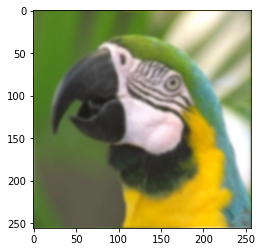

torch.Size([3, 256, 256])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
import cv2 as cv

cameraman = ImageFitting(fname)
sidelength1=gtimage.shape[1]
sidelength2=gtimage.shape[2]

dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True)
img_siren.cuda()

Train

In [ ]:
#total steps
total_steps = 4000
#test steps
steps_til_summary = 4000

#best_psnr=0


i=0
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
start_time = time.time()
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
for step in range(total_steps+1):
    model_output, coords = img_siren(model_input)    
    model_outputnew=(downsampler(model_output.view(1,sidelength1,sidelength2,3).permute(0,3,1,2))).permute(0,2,3,1).view(1,-1,3) 
    loss = ((model_outputnew - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        
        
        outimage=model_output.cpu().view(sidelength1,sidelength2,3).detach().numpy()
        gt=(np.array( Image.open(fname).resize([sidelength2,sidelength1])).astype(np.float32)/255)
              
        outimage=(outimage+1)/2      
        
        #print metrics
        SSIM = ssim(gt,outimage , multichannel=True)
        print("ssim = ", SSIM)
        PSNR = compare_PSNR(gt.transpose(2,0,1),outimage.transpose(2,0,1),True,False )
        print("psnr = ", PSNR)
        # Records best result
        # if PSNR>best_psnr:
        #   best_psnr=PSNR
        # print("best",best_psnr)
        end_time = time.time()
        print("time = ",(end_time - start_time))
       
        i=i+1
    
    optim.zero_grad()
    loss.backward()
    optim.step()



Step 0, Total loss 0.264139
ssim =  0.57966334
psnr =  14.057827137662354
time =  0.03540968894958496


<ipython-input-33-975f50c97c1c>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM = ssim(gt,outimage , multichannel=True)


Step 4000, Total loss 0.000108
ssim =  0.9630814
psnr =  32.91380798742925
time =  70.55534672737122
